In [1]:
import os

# Set the directory
os.chdir('/Users/ajibolaoluwatobiloba/Desktop/NHL ASSIGNMENT')

# Verify the change
print(os.getcwd())


/Users/ajibolaoluwatobiloba/Desktop/NHL ASSIGNMENT


16:48:33 - cmdstanpy - INFO - CmdStan start processing


Data Loading Complete:
Number of games: 1292
Number of teams: 32

Fitting Exercise 2 model...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:48:54 - cmdstanpy - INFO - CmdStan done processing.
16:48:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'stan-model-sog-xg.stan', line 83, column 8 to column 63)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'stan-model-sog-xg.stan', line 83, column 8 to column 63)
Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in 'stan-model-sog-xg.stan', line 83, column 8 to column 63)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in 'stan-model-sog-xg.stan', line 83, column 8 to column 63)
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'stan-model-sog-xg.stan', line 83, column 8 to column 63)
Consider re-running with show_console=True if the above output is unclear!


16:48:57 - cmdstanpy - INFO - compiling stan file /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmp2pcowshn/tmpz9zajq52.stan to exe file /Users/ajibolaoluwatobiloba/Desktop/NHL ASSIGNMENT/stan-model-combined



Fitting combined model...


16:49:06 - cmdstanpy - INFO - compiled model executable: /Users/ajibolaoluwatobiloba/Desktop/NHL ASSIGNMENT/stan-model-combined
16:49:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:50:00 - cmdstanpy - INFO - CmdStan done processing.




Model Diagnostics:
Processing csv files: /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpjwg644lr/stan-model-combined2l9pt2mq/stan-model-combined-20241124164906_1.csv, /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpjwg644lr/stan-model-combined2l9pt2mq/stan-model-combined-20241124164906_2.csv, /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpjwg644lr/stan-model-combined2l9pt2mq/stan-model-combined-20241124164906_3.csv, /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpjwg644lr/stan-model-combined2l9pt2mq/stan-model-combined-20241124164906_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Parameter Summaries:

Effects on Goals:
B2B effect: -0.0

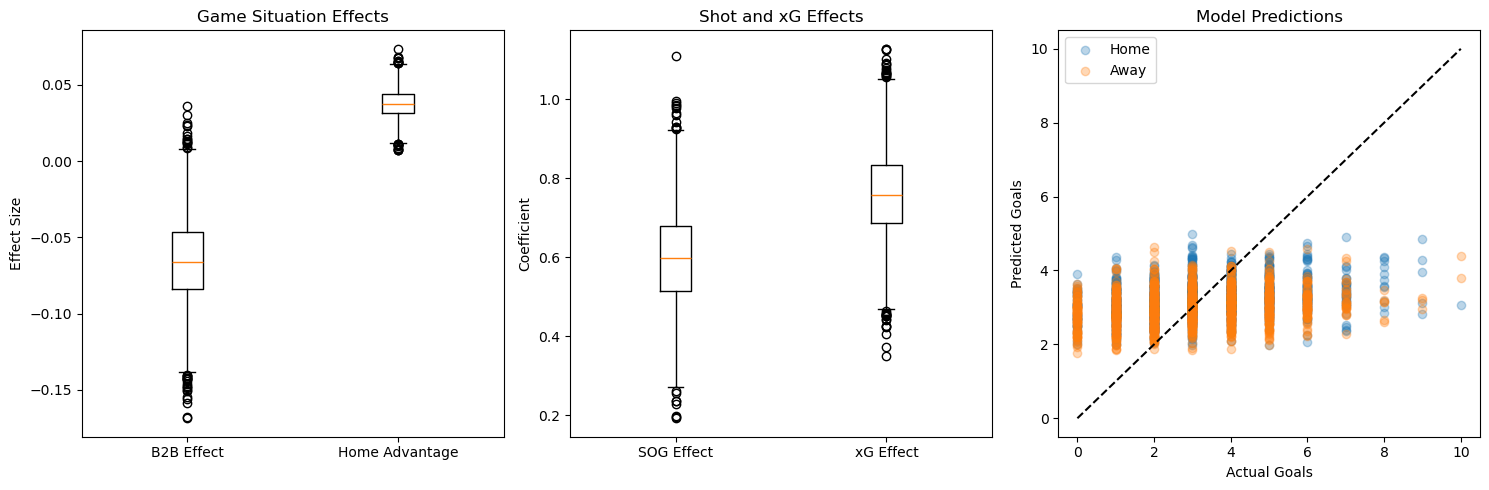

In [5]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()

# Read and prepare the data
df = pd.read_csv('model_inputs.csv')
df['date'] = pd.to_datetime(df['date'])

# Get season from game_id (first 4 digits)
df['season'] = df['game_id'].astype(str).str[:4].astype(int)

# Create a copy for the season data
df_season = df[df['season'] == 2023].copy()

# Create team indices (adding 1 for Stan's 1-based indexing)
home_inds, teams = pd.factorize(df_season['hm_team'], sort=True)
away_inds, _ = pd.factorize(df_season['aw_team'], sort=True)
df_season.loc[:, 'home_inds'] = home_inds + 1
df_season.loc[:, 'away_inds'] = away_inds + 1

print("Data Loading Complete:")
print(f"Number of games: {len(df_season)}")
print(f"Number of teams: {len(teams)}")

# First fit Exercise 2 model to get SOG and xG parameters
print("\nFitting Exercise 2 model...")
# Prepare data for SOG/xG model
data_sog_xg = {
    'N': len(df_season),
    'n_teams': len(teams),
    'home_team': df_season['home_inds'].values,
    'away_team': df_season['away_inds'].values,
    'home_total_sog': df_season['home_total_shots'].values,
    'away_total_sog': df_season['away_total_shots'].values,
    'home_total_xg': df_season['home_xG'].values,
    'away_total_xg': df_season['away_xG'].values,
    'home_b2b': df_season['hm_is_b2b'].values,
    'away_b2b': df_season['aw_is_b2b'].values
}

# Initialize Exercise 2 model
model_sog_xg = CmdStanModel(stan_file='stan-model-sog-xg.stan')

# Create initialization values for Exercise 2 model
init_values_sog_xg = [
    {
        'sigma_sog': 0.5,
        'sigma_xg': 0.5,
        'alpha_sog': 2.0,
        'alpha_xg': 1.0,
        'p_ha_sog': 0.1,
        'p_ha_xg': 0.1,
        'b2b_effect_sog': -0.1,
        'b2b_effect_xg': -0.1,
        'xg_sigma': 0.5,
        'team_sog_off': list(np.random.normal(0, 0.1, len(teams))),
        'team_sog_def': list(np.random.normal(0, 0.1, len(teams))),
        'team_xg_off': list(np.random.normal(0, 0.1, len(teams))),
        'team_xg_def': list(np.random.normal(0, 0.1, len(teams)))
    } for _ in range(4)
]

# Fit Exercise 2 model
fit_sog_xg = model_sog_xg.sample(
    data=data_sog_xg,
    chains=4,
    iter_warmup=1000,
    iter_sampling=1000,
    inits=init_values_sog_xg
)

# Get parameters from Exercise 2 model
team_sog_off = np.mean(fit_sog_xg.stan_variable('team_sog_off'), axis=0)
team_sog_def = np.mean(fit_sog_xg.stan_variable('team_sog_def'), axis=0)
team_xg_off = np.mean(fit_sog_xg.stan_variable('team_xg_off'), axis=0)
team_xg_def = np.mean(fit_sog_xg.stan_variable('team_xg_def'), axis=0)

# Now prepare data for the combined model
data_combined = {
    'N': len(df_season),
    'n_teams': len(teams),
    'home_team': df_season['home_inds'].values,
    'away_team': df_season['away_inds'].values,
    'home_total_goals': df_season['home_total_goals'].values,
    'away_total_goals': df_season['away_total_goals'].values,
    'home_b2b': df_season['hm_is_b2b'].values,
    'away_b2b': df_season['aw_is_b2b'].values,
    'team_sog_off': team_sog_off,
    'team_sog_def': team_sog_def,
    'team_xg_off': team_xg_off,
    'team_xg_def': team_xg_def
}

# Initialize the combined model
print("\nFitting combined model...")
model_combined = CmdStanModel(stan_file='stan-model-combined.stan')

# Create initialization values for combined model
init_values_combined = [
    {
        'sigma': 0.1,
        'alpha': 1.0,
        'p_ha': 0.05,
        'b2b_effect': -0.05,
        'beta_sog': 0.1,
        'beta_xg': 0.5,
        'team_goal_off': list(np.random.normal(0, 0.1, len(teams))),
        'team_goal_def': list(np.random.normal(0, 0.1, len(teams)))
    } for _ in range(4)
]

# Fit the combined model
fit_combined = model_combined.sample(
    data=data_combined,
    chains=4,
    iter_warmup=1000,
    iter_sampling=1000,
    inits=init_values_combined
)

# Print diagnostics
print("\nModel Diagnostics:")
print(fit_combined.diagnose())

# Extract and analyze parameters
print("\nParameter Summaries:")
b2b_effect = fit_combined.stan_variable('b2b_effect')
p_ha = fit_combined.stan_variable('p_ha')
beta_sog = fit_combined.stan_variable('beta_sog')
beta_xg = fit_combined.stan_variable('beta_xg')

print("\nEffects on Goals:")
print(f"B2B effect: {np.mean(b2b_effect):.3f} ± {np.std(b2b_effect):.3f}")
print(f"Home advantage: {np.mean(p_ha):.3f} ± {np.std(p_ha):.3f}")
print(f"SOG effect: {np.mean(beta_sog):.3f} ± {np.std(beta_sog):.3f}")
print(f"xG effect: {np.mean(beta_xg):.3f} ± {np.std(beta_xg):.3f}")

# Calculate model performance
lambda_home = np.mean(fit_combined.stan_variable('lambda_home'), axis=0)
lambda_away = np.mean(fit_combined.stan_variable('lambda_away'), axis=0)

def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

print("\nModel Performance (RMSE):")
print(f"Home goals: {rmse(df_season['home_total_goals'], lambda_home):.3f}")
print(f"Away goals: {rmse(df_season['away_total_goals'], lambda_away):.3f}")

# Create visualizations
plt.figure(figsize=(15, 5))

# Plot 1: B2B and Home Advantage Effects
plt.subplot(1, 3, 1)
plt.boxplot([b2b_effect, p_ha], labels=['B2B Effect', 'Home Advantage'])
plt.title('Game Situation Effects')
plt.ylabel('Effect Size')

# Plot 2: SOG and xG Effects
plt.subplot(1, 3, 2)
plt.boxplot([beta_sog, beta_xg], labels=['SOG Effect', 'xG Effect'])
plt.title('Shot and xG Effects')
plt.ylabel('Coefficient')

# Plot 3: Actual vs Predicted Goals
plt.subplot(1, 3, 3)
plt.scatter(df_season['home_total_goals'], lambda_home, alpha=0.3, label='Home')
plt.scatter(df_season['away_total_goals'], lambda_away, alpha=0.3, label='Away')
plt.plot([0, max(df_season['home_total_goals'].max(), df_season['away_total_goals'].max())], 
         [0, max(df_season['home_total_goals'].max(), df_season['away_total_goals'].max())], 
         'k--')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.title('Model Predictions')
plt.legend()

plt.tight_layout()
plt.show()